# Data Analysis of European Soccer Database with SQL

In [305]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 

In [306]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [307]:
for row in c.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(list(row))

['sqlite_sequence']
['Player_Attributes']
['Player']
['Match']
['League']
['Country']
['Team']
['Team_Attributes']


### Inspect the database

In [308]:
player = pd.read_sql_query(
    '''
    SELECT * 
    FROM Player
    LIMIT 1
    ''', conn, index_col='id'
)
player

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
id,,,,,,
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187


In [309]:
match = pd.read_sql_query(
    '''
    SELECT * 
    FROM Match
    LIMIT 1
    ''', conn, index_col='id'
)
match

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
id,,,,,,,,,,,,,,,,,,,,,
1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,...,4,1.65,3.4,4.5,1.78,3.25,4,1.73,3.4,4.2


In [310]:
league = pd.read_sql_query(
    '''
    SELECT * 
    FROM League
    LIMIT 1
    ''', conn, index_col='id'
)
league

,country_id,name
id,,
1,1,Belgium Jupiler League


In [311]:
country = pd.read_sql_query(
    '''
    SELECT * 
    FROM Country
    LIMIT 1
    ''', conn, index_col='id'
)
country

,name
id,
1,Belgium


In [312]:
team = pd.read_sql_query(
    '''
    SELECT * 
    FROM Team
    LIMIT 1
    ''', conn, index_col='id'
)
team

,team_api_id,team_fifa_api_id,team_long_name,team_short_name
id,,,,
1,9987,673,KRC Genk,GEN


### Queries and Analyses

Query 1) Number of teams in each country

In [313]:
q1 = pd.read_sql_query(
    '''
    SELECT 
    c.name AS country,
    COUNT(DISTINCT(team_long_name)) AS number_of_teams
    FROM Match AS m
    LEFT JOIN Country AS c
    ON m.country_id = c.id
    LEFT JOIN Team AS t 
    ON m.home_team_api_id = t.team_api_id
    GROUP BY 1
    ''', conn
)
q1

,country,number_of_teams
0,Belgium,24
1,England,34
2,France,35
3,Germany,30
4,Italy,32
5,Netherlands,25
6,Poland,22
7,Portugal,29
8,Scotland,17
9,Spain,33


In [314]:
def PLOT(col1, col2, col3, query, title):
    plt.figure(figsize=(8, 5))
    sns.barplot(y=col1, x=col2, data = query.sort_values(by=[col3], ascending=False), color = 'teal')
    plt.title(title)
    plt.show();

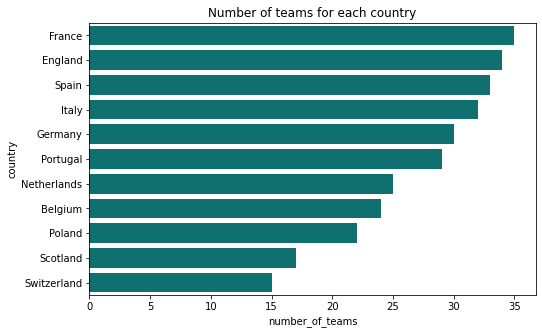

In [315]:
PLOT('country', 'number_of_teams', 'number_of_teams', q1, "Number of teams for each country")

Query 3) Total goals scored by home team grouped by country and Season

In [316]:
q2 = pd.read_sql_query(
    '''
    SELECT 
        c.name AS country,
        m.season,
        SUM(m.home_team_goal) AS home_goal,
        SUM(m.away_team_goal) AS away_goal
    FROM match AS m
    JOIN league AS l 
    ON l.id = m.league_id
    JOIN country as c
    on c.id = l.country_id
    GROUP BY 1,2
    ORDER BY 2
    ''', conn)
q2

,country,season,home_goal,away_goal
0,Belgium,2008/2009,499,356
1,England,2008/2009,532,410
2,France,2008/2009,489,369
3,Germany,2008/2009,520,374
4,Italy,2008/2009,578,410
...,...,...,...,...
83,Poland,2015/2016,341,294
84,Portugal,2015/2016,463,368
85,Scotland,2015/2016,343,307
86,Spain,2015/2016,615,428


Query 3) Goals scored by each team grouped by season

In [317]:
q3 = pd.read_sql_query(
    '''
    SELECT 
        t.team_long_name AS team_name,
        m.season AS season,
        SUM(m.home_team_goal) AS home_goal,
        SUM(m.away_team_goal) AS away_goal
    FROM team AS t
    JOIN match AS m
    ON t.team_api_id = m.home_team_api_id
    GROUP BY 1,2
    ORDER BY 3 DESC
    ''', conn)
q3

,team_name,season,home_goal,away_goal
0,FC Barcelona,2011/2012,73,11
1,Real Madrid CF,2011/2012,70,19
2,Real Madrid CF,2015/2016,70,16
3,Chelsea,2009/2010,68,14
4,FC Barcelona,2015/2016,67,14
...,...,...,...,...
1473,Lechia Gdańsk,2011/2012,9,13
1474,KAA Gent,2013/2014,6,2
1475,Lierse SK,2013/2014,5,4
1476,Waasland-Beveren,2013/2014,4,5


Query 4) Count of matches won, lost and tie

In [318]:
q4 = pd.read_sql_query(
    '''
    SELECT 
        t.team_long_name AS team_name,
        COUNT(m.id) AS no_of_matches,
        COUNT(CASE WHEN m.home_team_goal > m.away_team_goal THEN 'Win' END) AS Won,
        COUNT(CASE WHEN m.home_team_goal < m.away_team_goal THEN 'Lost' END) AS Lost,
        COUNT(CASE WHEN m.home_team_goal = m.away_team_goal THEN 'Tie' END) AS Tie
    FROM team AS t
    JOIN match AS m
    ON t.team_api_id = m.home_team_api_id 
    GROUP BY 1
    ORDER BY 2 DESC
    ''', conn)
q4

,team_name,no_of_matches,Won,Lost,Tie
0,Valencia CF,152,90,28,34
1,Toulouse FC,152,62,40,50
2,Tottenham Hotspur,152,88,28,36
3,Sunderland,152,49,56,47
4,Stoke City,152,69,40,43
...,...,...,...,...,...
291,Termalica Bruk-Bet Nieciecza,15,5,6,4
292,Portimonense,15,4,8,3
293,KAS Eupen,15,3,9,3
294,Feirense,15,3,5,7


Query 5) Total home goals scored grouped by country and team

In [319]:
q5 = pd.read_sql_query(
    '''
    SELECT
        c.name AS country,
        t.team_long_name AS team_name,
        SUM(m.home_team_goal) AS total_home_goals
    FROM country AS c
    JOIN league AS l
    ON c.id = l.country_id
    JOIN match AS m
    ON m.league_id = l.id
    JOIN team AS t
    ON t.team_api_id = m.home_team_api_id
    GROUP BY 1,2
    ORDER BY 3 DESC
    LIMIT 10
    ''', conn)
q5

,country,team_name,total_home_goals
0,Spain,Real Madrid CF,505
1,Spain,FC Barcelona,495
2,Scotland,Celtic,389
3,Germany,FC Bayern Munich,382
4,Netherlands,PSV,370
5,England,Manchester City,365
6,Netherlands,Ajax,360
7,Switzerland,FC Basel,344
8,England,Manchester United,338
9,England,Chelsea,333


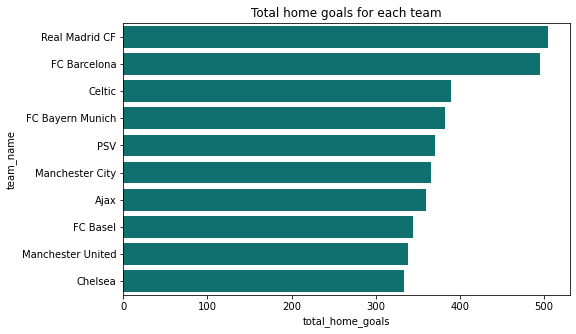

In [320]:
PLOT('team_name', 'total_home_goals', 'total_home_goals', q5, 'Total home goals for each team')

Query 6) Total goals scored grouped by country and year

In [321]:
q6 = pd.read_sql_query(
    '''
    SELECT 
        c.name AS country,
        STRFTIME('%Y', m.date) AS year,
        SUM(m.home_team_goal) AS total_goals
    FROM country AS c
    JOIN match AS m
    ON c.id = m.country_id
    GROUP BY 1,2
    ORDER BY 3 DESC
    ''', conn)
q6

,country,year,total_goals
0,Spain,2012,661
1,Spain,2013,640
2,Spain,2010,632
3,England,2012,631
4,Spain,2011,619
...,...,...,...
94,Switzerland,2008,142
95,Belgium,2016,134
96,Poland,2016,110
97,Portugal,2008,110


Query 7) Extracting Year, Month, Week and day from date

In [322]:
q7 = pd.read_sql_query(
    '''
    SELECT
        STRFTIME('%Y', date) AS year,
        STRFTIME('%m', date) AS month,
        STRFTIME('%w', date) AS week,
        STRFTIME('%d', date) AS day
    FROM match
    ''', conn)
q7

,year,month,week,day
0,2008,08,0,17
1,2008,08,6,16
2,2008,08,6,16
3,2008,08,0,17
4,2008,08,6,16
...,...,...,...,...
25974,2015,09,2,22
25975,2015,09,3,23
25976,2015,09,3,23
25977,2015,09,2,22


Query 8) Count of matches won, lost and tie

In [323]:
q8 = pd.read_sql_query(
    '''
    SELECT 
        c.name AS country,
        m.season AS season,
        COUNT(m.id) AS no_of_matches,
        COUNT(CASE WHEN m.home_team_goal > m.away_team_goal THEN 'Win' END) AS Won,
        COUNT(CASE WHEN m.home_team_goal < m.away_team_goal THEN 'Lost' END) AS Lost,
        COUNT(CASE WHEN m.home_team_goal = m.away_team_goal THEN 'Tie' END) AS Tie
    FROM country AS c
    JOIN match AS m
    ON c.id = m.country_id
    GROUP BY 1,2
    ORDER BY 4 DESC 
    ''', conn)
q8

,country,season,no_of_matches,Won,Lost,Tie
0,Spain,2010/2011,380,197,104,79
1,Spain,2009/2010,380,194,91,95
2,England,2009/2010,380,193,91,96
3,Italy,2008/2009,380,192,93,95
4,Spain,2012/2013,380,189,107,84
...,...,...,...,...,...,...
83,Switzerland,2015/2016,180,80,53,47
84,Switzerland,2014/2015,180,76,56,48
85,Switzerland,2010/2011,180,72,57,51
86,Switzerland,2011/2012,162,70,52,40


Query 9) Partitioning by Season and Country

In [324]:
q9 = pd.read_sql_query(
    '''
    WITH cte AS(
        SELECT
            c.name AS country,
            m.season AS season,
            t.team_long_name AS team_name,
            SUM(m.home_team_goal) AS total_goals
        FROM country AS c
        JOIN match AS m
        ON c.id = m.country_id
        JOIN team AS t
        ON t.team_api_id = m.home_team_api_id
        GROUP BY 1,2,3
        ORDER BY 4 DESC)
    
    SELECT 
        ROW_NUMBER() OVER(PARTITION BY country, season ORDER BY total_goals DESC) AS row_number,
        country,
        season,
        team_name,
        total_goals
    FROM cte
    ''', conn, index_col='row_number')
q9

,country,season,team_name,total_goals
row_number,,,,
1,Belgium,2008/2009,RSC Anderlecht,48
2,Belgium,2008/2009,Standard de Liège,42
3,Belgium,2008/2009,Club Brugge KV,37
4,Belgium,2008/2009,Beerschot AC,32
5,Belgium,2008/2009,KAA Gent,31
...,...,...,...,...
6,Switzerland,2015/2016,FC Zürich,29
7,Switzerland,2015/2016,FC Thun,26
8,Switzerland,2015/2016,FC St. Gallen,25


In [325]:
top_10 = q9.groupby(['country'])['total_goals'].sum()
pd.DataFrame(top_10).style.applymap(lambda x: "background-color: limegreen" if x>4000 else "background-color: salmon")

,total_goals
country,
Belgium,2781
England,4715
France,4265
Germany,3982
Italy,4528
Netherlands,4357
Poland,2678
Portugal,2890
Scotland,2607


Query 10) Concatenating team name with country name

In [326]:
q10 = pd.read_sql_query(
    '''
    WITH cte AS(
        SELECT 
            t.team_long_name || ' (' || c.name || ')' AS team,
            m.season AS season,
            SUM(m.home_team_goal) AS total_goals
        FROM team AS t
        JOIN match AS m
        ON t.team_api_id = m.home_team_api_id
        JOIN country AS c
        ON c.id = m.country_id
        GROUP BY 1,2
        ORDER BY 3 DESC)
    
    SELECT
       team,
       total_goals
    FROM cte
    ''', conn)
q10

,team,total_goals
0,FC Barcelona (Spain),73
1,Real Madrid CF (Spain),70
2,Real Madrid CF (Spain),70
3,Chelsea (England),68
4,FC Barcelona (Spain),67
...,...,...
1473,Lechia Gdańsk (Poland),9
1474,KAA Gent (Belgium),6
1475,Lierse SK (Belgium),5
1476,Waasland-Beveren (Belgium),4
